In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
batch_size = 1
num_workers = 2
epochs = 100
learning_rate = 0.01
betas = (0.9, 0.999)
PATH = '../data/saved_model/GAN.pth'

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.MNIST(root = '../data', train=True,
                                       download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)

testset = torchvision.datasets.MNIST(root = '../data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False, num_workers=num_workers)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress',
          'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

def imshow(img):
    npimg = img.numpy()
    plt.imshow(npimg)
    plt.show


In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv = nn.Sequential(
            # 28 * 28 * 1
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            # 28 * 28 * 16
            nn.MaxPool2d(2, 2),
            # 14 * 14 * 16
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            # 14 * 14 * 32
            nn.MaxPool2d(2, 2),
            # 7 * 7 * 32
        )     
        self.fc = nn.Sequential(
            nn.Linear(7 * 7 * 32, 120),
            nn.Dropout(),
            nn.ReLU(inplace=True),
            nn.Linear(120, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        out = self.conv(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        
        self.fc = nn.Sequential(
            nn.Linear(10 * 10 * 1, 120),
            nn.Dropout(),
            nn.ReLU(inplace=True),
            nn.Linear(120, 28 * 28 * 1),
            nn.Tanh()
        )
    def forward(self, x):
        out = self.fc(x)
        out = out.view(1, 1, 28, 28)
        return out

In [5]:
D = Discriminator()
D.to(device)

Discriminator(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=1568, out_features=120, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=120, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

In [6]:
G = Generator()
G.to(device)

Generator(
  (fc): Sequential(
    (0): Linear(in_features=100, out_features=120, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=120, out_features=784, bias=True)
    (4): Tanh()
  )
)

In [7]:
criterion = nn.BCELoss()
D_optimizer = optim.Adam(D.parameters(), lr=learning_rate, betas=betas)
G_optimizer = optim.Adam(G.parameters(), lr=learning_rate, betas=betas)

In [8]:
total_steps = len(trainloader)
cnt = 0
all_D_losses = []
all_G_losses = []
for epoch in range(epochs):
    D_running_loss = 0.
    G_running_loss = 0.
    for i, (images, labels) in enumerate(trainloader, 0):
        if i % 1000 == 999:
            print("[{epoch}, {index}] D_loss: {D_loss} G_loss: {G_loss}".format(epoch = epoch + 1, index = i + 1, D_loss = D_running_loss / cnt, G_loss = G_running_loss / cnt))
            all_D_losses.append(D_running_loss / cnt)
            all_G_losses.append(G_running_loss / cnt)
        if labels[0] != 5:
            continue
        cnt += 1
        # Train Discriminator
        images = images.to(device)
        fake_images = torch.randn(1, 10 * 10).to(device)
        
        
        D_loss = criterion(D(images), torch.tensor(1.).to(device)) + criterion(D(G(fake_images)), torch.tensor(0.).to(device))
        
        
        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()
        
        # Train Generator
        
        G_loss = criterion(D(G(fake_images)), torch.tensor(1.).to(device))
        
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()
        
        D_running_loss += D_loss.item() 
        G_running_loss += G_loss.item()
    print("epoch: {epoch}, D_loss: {D_loss}, G_loss: {G_loss}".format(epoch = epoch, D_loss = D_running_loss / cnt, G_loss = G_running_loss / cnt))
print("Finished Training")

/home/jun/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1, 1000] D_loss: 3.1116958625594764 G_loss: 28.257725324461152
[1, 2000] D_loss: 1.8678130633259562 G_loss: 32.62342168630477
[1, 3000] D_loss: 1.2863411304442904 G_loss: 32.903113323750304
[1, 4000] D_loss: 1.058638391487771 G_loss: 29.138787393459253
[1, 5000] D_loss: 0.803637171373433 G_loss: 24.964656758054563
[1, 6000] D_loss: 0.6987313901016715 G_loss: 22.57688865613632
[1, 7000] D_loss: 0.5994813073263444 G_loss: 20.783303029381905
[1, 8000] D_loss: 0.527263199784138 G_loss: 20.083716325259587
[1, 9000] D_loss: 0.4637220563055754 G_loss: 19.12269497691336
[1, 10000] D_loss: 0.4116366357458835 G_loss: 18.33444384181836
[1, 11000] D_loss: 0.3766714187031121 G_loss: 17.824567081103712
[1, 12000] D_loss: 0.34676786342524224 G_loss: 17.4799541781307
[1, 13000] D_loss: 0.32131799262482735 G_loss: 17.14598354903093
[1, 14000] D_loss: 0.2988859444538929 G_loss: 16.82316439148153
[1, 15000] D_loss: 0.2790529851492941 G_loss: 16.684398047759338
[1, 16000] D_loss: 0.26270310999998253 G_lo

[3, 4000] D_loss: 4.970539805785274e-08 G_loss: 1.240545926409706
[3, 5000] D_loss: 2.6171375345450566e-05 G_loss: 1.5814573860282402
[3, 6000] D_loss: 2.5996516046439206e-05 G_loss: 1.8444268936220105
[3, 7000] D_loss: 2.5778994583342153e-05 G_loss: 2.1876717347772856
[3, 8000] D_loss: 2.5564383473535747e-05 G_loss: 2.532769851159835
[3, 9000] D_loss: 6.915958514831846e-05 G_loss: 2.8316699551492737
[3, 10000] D_loss: 6.864580611170384e-05 G_loss: 3.1724146493197543
[3, 11000] D_loss: 6.804385300583392e-05 G_loss: 3.479337104948938
[3, 12000] D_loss: 6.742418720437717e-05 G_loss: 3.7998411201855045
[3, 13000] D_loss: 6.687665314381533e-05 G_loss: 4.121105960935411
[3, 14000] D_loss: 6.647368980065546e-05 G_loss: 4.385410294692585
[3, 15000] D_loss: 6.58564880765363e-05 G_loss: 4.737061903568489
[3, 16000] D_loss: 8.339547468423647e-05 G_loss: 4.972608406208652
[3, 17000] D_loss: 8.278525035345021e-05 G_loss: 5.2448181424945375
[3, 18000] D_loss: 8.219091437657898e-05 G_loss: 5.4877630

[5, 4000] D_loss: 8.115733151955094e-12 G_loss: 0.7359889239128257
[5, 5000] D_loss: 8.086372203546628e-12 G_loss: 0.889635187883161
[5, 6000] D_loss: 7.905180125737792e-07 G_loss: 1.0662251643017606
[5, 7000] D_loss: 7.873261498043023e-07 G_loss: 1.257599499729408
[5, 8000] D_loss: 7.839147665671103e-07 G_loss: 1.461735547805645
[5, 9000] D_loss: 1.4488810914896983e-06 G_loss: 1.6869518761848303
[5, 10000] D_loss: 1.442979074203134e-06 G_loss: 1.870418517125611
[5, 11000] D_loss: 1.4376025655808502e-06 G_loss: 2.0405769361184936
[5, 12000] D_loss: 1.4311635605446563e-06 G_loss: 2.234261424478762
[5, 13000] D_loss: 1.4264688157745296e-06 G_loss: 2.3831534448491527
[5, 14000] D_loss: 1.4197820179989236e-06 G_loss: 2.607677758999146
[5, 15000] D_loss: 1.98063529417448e-06 G_loss: 2.783526340516898
[5, 16000] D_loss: 1.9722119271979805e-06 G_loss: 2.9682168005413554
[5, 17000] D_loss: 1.9637296699240595e-06 G_loss: 3.1605289041062594
[5, 18000] D_loss: 1.955652632721287e-06 G_loss: 3.3541

[7, 6000] D_loss: 1.6315209875454261e-09 G_loss: 0.4652876367197745
[7, 7000] D_loss: 8.886948318888904e-07 G_loss: 0.558359105538114
[7, 8000] D_loss: 8.863693152896685e-07 G_loss: 0.6324717659381872
[7, 9000] D_loss: 8.839233517932633e-07 G_loss: 0.7123550733531214
[7, 10000] D_loss: 1.7380763749933818e-06 G_loss: 0.7938972140278395
[7, 11000] D_loss: 1.7331519116583275e-06 G_loss: 0.8740769021090841
[7, 12000] D_loss: 1.7284094818245114e-06 G_loss: 0.9516769385296701
[7, 13000] D_loss: 1.7245625307268813e-06 G_loss: 1.0164472145698444
[7, 14000] D_loss: 1.7199178287529218e-06 G_loss: 1.0904051144334483
[7, 15000] D_loss: 1.7155512663961657e-06 G_loss: 1.1570527711711076
[7, 16000] D_loss: 1.7104009770986497e-06 G_loss: 1.2401237604349733
[7, 17000] D_loss: 1.7057320026388717e-06 G_loss: 1.312164427602941
[7, 18000] D_loss: 1.701985227211332e-06 G_loss: 1.3709069043886695
[7, 19000] D_loss: 1.6972133060135432e-06 G_loss: 1.4537448432192066
[7, 20000] D_loss: 1.6927128462845092e-06 G_

[9, 5000] D_loss: 1.8540465774844777e-07 G_loss: 0.31494852831728387
[9, 6000] D_loss: 1.8504597609269936e-07 G_loss: 0.37045464404011264
[9, 7000] D_loss: 3.2946362401027785e-07 G_loss: 0.4213341165431833
[9, 8000] D_loss: 3.288285602181633e-07 G_loss: 0.47878932758240206
[9, 9000] D_loss: 4.467458137657184e-07 G_loss: 0.5253587710903272
[9, 10000] D_loss: 4.4604901996048246e-07 G_loss: 0.5693426587061619
[9, 11000] D_loss: 4.4518358926185633e-07 G_loss: 0.6235070901258611
[9, 12000] D_loss: 4.442214851991577e-07 G_loss: 0.6839652055343738
[9, 13000] D_loss: 4.431938413896277e-07 G_loss: 0.7475039155728925
[9, 14000] D_loss: 5.430206126237759e-07 G_loss: 0.8008743522787704
[9, 15000] D_loss: 5.418746707766948e-07 G_loss: 0.8582930849244058
[9, 16000] D_loss: 5.40725606184646e-07 G_loss: 0.9189836737194231
[9, 17000] D_loss: 5.396174631799016e-07 G_loss: 0.9770545444630434
[9, 18000] D_loss: 5.385976645190239e-07 G_loss: 1.0285688226462646
[9, 19000] D_loss: 5.374505170960917e-07 G_los

[11, 5000] D_loss: 0.0 G_loss: 0.2407645031295053
[11, 6000] D_loss: 0.0 G_loss: 0.2897640684104863
[11, 7000] D_loss: 7.080826028263909e-08 G_loss: 0.32877476589388266
[11, 8000] D_loss: 7.067427572841263e-08 G_loss: 0.38043652602468125
[11, 9000] D_loss: 7.05574544999367e-08 G_loss: 0.4254804515618623
[11, 10000] D_loss: 7.04537951642365e-08 G_loss: 0.4654494149037897
[11, 11000] D_loss: 7.035171410484688e-08 G_loss: 0.5048098265163952
[11, 12000] D_loss: 7.023468597593417e-08 G_loss: 0.5499335287173643
[11, 13000] D_loss: 7.012310976974068e-08 G_loss: 0.5929550787307348
[11, 14000] D_loss: 7.000305542693175e-08 G_loss: 0.6389730532000182
[11, 15000] D_loss: 6.990982385013436e-08 G_loss: 0.6759005055289297
[11, 16000] D_loss: 6.980178516388462e-08 G_loss: 0.7175569666601812
[11, 17000] D_loss: 6.968032760350546e-08 G_loss: 0.7643873412107937
[11, 18000] D_loss: 6.956053763448686e-08 G_loss: 0.8113639390142833
[11, 19000] D_loss: 6.945109141042402e-08 G_loss: 0.853561862585435
[11, 20

[13, 4000] D_loss: 0.0 G_loss: 0.15383646626141897
[13, 5000] D_loss: 0.0 G_loss: 0.1850092232795266
[13, 6000] D_loss: 0.0 G_loss: 0.21849630511988077
[13, 7000] D_loss: 0.0 G_loss: 0.2597031075929203
[13, 8000] D_loss: 0.0 G_loss: 0.2986587201461074
[13, 9000] D_loss: 0.0 G_loss: 0.3315607595264831
[13, 10000] D_loss: 0.0 G_loss: 0.3700690235766876
[13, 11000] D_loss: 0.0 G_loss: 0.4047574231281281
[13, 12000] D_loss: 0.0 G_loss: 0.4531970121304872
[13, 13000] D_loss: 0.0 G_loss: 0.4864443167910186
[13, 14000] D_loss: 0.0 G_loss: 0.5213849308936792
[13, 15000] D_loss: 0.0 G_loss: 0.557447058575847
[13, 16000] D_loss: 0.0 G_loss: 0.589627555707237
[13, 17000] D_loss: 0.0 G_loss: 0.6258006743181029
[13, 18000] D_loss: 0.0 G_loss: 0.6603943221293401
[13, 19000] D_loss: 0.0 G_loss: 0.6955633828832916
[13, 20000] D_loss: 0.0 G_loss: 0.7250995086423883
[13, 21000] D_loss: 0.0 G_loss: 0.7665266487564775
[13, 22000] D_loss: 0.0 G_loss: 0.8109213049664695
[13, 23000] D_loss: 0.0 G_loss: 0.846

[15, 16000] D_loss: 4.10717297280152e-09 G_loss: 0.5264857458482445
[15, 17000] D_loss: 4.101606117298033e-09 G_loss: 0.563223189104137
[15, 18000] D_loss: 4.0971634863684236e-09 G_loss: 0.5932128466796402
[15, 19000] D_loss: 4.091518339082965e-09 G_loss: 0.6304660372417914
[15, 20000] D_loss: 4.08688724574381e-09 G_loss: 0.6610273306767857
[15, 21000] D_loss: 4.081899523327304e-09 G_loss: 0.6946639062713822
[15, 22000] D_loss: 7.0904731203088734e-09 G_loss: 0.724705218161284
[15, 23000] D_loss: 7.0832924801629345e-09 G_loss: 0.751953692500279
[15, 24000] D_loss: 7.075854524171471e-09 G_loss: 0.7801786068322671
[15, 25000] D_loss: 7.0667145808667265e-09 G_loss: 0.8148620759293876
[15, 26000] D_loss: 7.0597623523349286e-09 G_loss: 0.841243793561437
[15, 27000] D_loss: 7.052373705074029e-09 G_loss: 0.8692815953725147
[15, 28000] D_loss: 7.0441921927633535e-09 G_loss: 0.900328093138833
[15, 29000] D_loss: 7.036477641990019e-09 G_loss: 0.9296026055098463
[15, 30000] D_loss: 7.0278859849223

[17, 19000] D_loss: 0.0 G_loss: 0.5471193326338866
[17, 20000] D_loss: 8.265077723694328e-10 G_loss: 0.5731620638031469
[17, 21000] D_loss: 8.25584883281056e-10 G_loss: 0.6033752137128844
[17, 22000] D_loss: 8.246826352169011e-10 G_loss: 0.6335525252244814
[17, 23000] D_loss: 8.238287150994002e-10 G_loss: 0.661507324686732
[17, 24000] D_loss: 8.230413373427976e-10 G_loss: 0.6881285022039226
[17, 25000] D_loss: 8.221446371706993e-10 G_loss: 0.7179165402344803
[17, 26000] D_loss: 8.211853946394465e-10 G_loss: 0.749317578151568
[17, 27000] D_loss: 8.202375792711898e-10 G_loss: 0.7803445451044997
[17, 28000] D_loss: 8.195671504006372e-10 G_loss: 0.8022911974880611
[17, 29000] D_loss: 8.187329433752973e-10 G_loss: 0.8300424618068872
[17, 30000] D_loss: 8.181289758081761e-10 G_loss: 0.8498131602219425
[17, 31000] D_loss: 1.4141970996335472e-09 G_loss: 0.8788172154317648
[17, 32000] D_loss: 1.4124938937236912e-09 G_loss: 0.9110365662212224
[17, 33000] D_loss: 1.4109362216454645e-09 G_loss: 0.

[19, 20000] D_loss: 2.2373959568657816e-10 G_loss: 0.5002392125926995
[19, 21000] D_loss: 2.235303923486315e-10 G_loss: 0.5256073205404065
[19, 22000] D_loss: 2.2333952689462853e-10 G_loss: 0.5487517669348024
[19, 23000] D_loss: 2.231310706922881e-10 G_loss: 0.5740292768218057
[19, 24000] D_loss: 2.229230032564907e-10 G_loss: 0.5998321309082537
[19, 25000] D_loss: 2.226997073490688e-10 G_loss: 0.6269085378766164
[19, 26000] D_loss: 2.2247463209497855e-10 G_loss: 0.6542007047981594
[19, 27000] D_loss: 2.222811198026373e-10 G_loss: 0.6780290137007478
[19, 28000] D_loss: 2.220191921606925e-10 G_loss: 0.7094577461831381
[19, 29000] D_loss: 2.2181319223181803e-10 G_loss: 0.7344368489554155
[19, 30000] D_loss: 2.2166502042671995e-10 G_loss: 0.7524038393700303
[19, 31000] D_loss: 2.2145305925374356e-10 G_loss: 0.7786566474652752
[19, 32000] D_loss: 2.212326969877067e-10 G_loss: 0.8053767478206845
[19, 33000] D_loss: 2.2101716703726488e-10 G_loss: 0.8315109041305438
[19, 34000] D_loss: 2.20802

[21, 19000] D_loss: 6.492668057531067e-11 G_loss: 0.44001003767097835
[21, 20000] D_loss: 6.488427409284195e-11 G_loss: 0.45831721327925046
[21, 21000] D_loss: 6.483957175011354e-11 G_loss: 0.47709182117249693
[21, 22000] D_loss: 6.47937570332324e-11 G_loss: 0.49613541211649087
[21, 23000] D_loss: 6.47321855187884e-11 G_loss: 0.5224445743492606
[21, 24000] D_loss: 6.469354328288027e-11 G_loss: 0.5386271891688514
[21, 25000] D_loss: 6.464384468393367e-11 G_loss: 0.5599001663000045
[21, 26000] D_loss: 1.2917094683146163e-10 G_loss: 0.5843444995791602
[21, 27000] D_loss: 2.5808321852110464e-10 G_loss: 0.6114260654433462
[21, 28000] D_loss: 2.5788780843506097e-10 G_loss: 0.6318842009971269
[21, 29000] D_loss: 2.5769733618794393e-10 G_loss: 0.6518253776766277
[21, 30000] D_loss: 2.574886048940637e-10 G_loss: 0.6736781550381978
[21, 31000] D_loss: 3.21562672587511e-10 G_loss: 0.6986440445189681
[21, 32000] D_loss: 3.2129400313085754e-10 G_loss: 0.7211463678111159
[21, 33000] D_loss: 3.210056

[23, 26000] D_loss: 0.0 G_loss: 0.5327912978514842
[23, 27000] D_loss: 0.0 G_loss: 0.5526111780973577
[23, 28000] D_loss: 0.0 G_loss: 0.5715388829249574
[23, 29000] D_loss: 0.0 G_loss: 0.5913024868221063
[23, 30000] D_loss: 0.0 G_loss: 0.6103724947366044
[23, 31000] D_loss: 0.0 G_loss: 0.6296368968691154
[23, 32000] D_loss: 5.856676114944709e-11 G_loss: 0.651525071275051
[23, 33000] D_loss: 5.85188447634199e-11 G_loss: 0.673598341852222
[23, 34000] D_loss: 5.84767431541391e-11 G_loss: 0.6938819886189531
[23, 35000] D_loss: 5.842992851166563e-11 G_loss: 0.7154470157980881
[23, 36000] D_loss: 5.838461846490453e-11 G_loss: 0.736190152875893
[23, 37000] D_loss: 5.833985447952337e-11 G_loss: 0.7566819458952448
[23, 38000] D_loss: 5.829088332911067e-11 G_loss: 0.7792405781762037
[23, 39000] D_loss: 5.824816025814182e-11 G_loss: 0.7989210234950782
[23, 40000] D_loss: 5.821260550906262e-11 G_loss: 0.8152993708191638
[23, 41000] D_loss: 5.8168577855928406e-11 G_loss: 0.8359211564096019
[23, 420

[25, 31000] D_loss: 7.177284503720527e-12 G_loss: 0.5766321938133725
[25, 32000] D_loss: 7.172372437463703e-12 G_loss: 0.5951479643306489
[25, 33000] D_loss: 7.1676286979426345e-12 G_loss: 0.6130292362381344
[25, 34000] D_loss: 7.162191906719748e-12 G_loss: 0.6335229293949526
[25, 35000] D_loss: 7.157461619814783e-12 G_loss: 0.6514632302666434
[25, 36000] D_loss: 7.15279122432e-12 G_loss: 0.6690679641912581
[25, 37000] D_loss: 7.147376910345209e-12 G_loss: 0.6894768475539179
[25, 38000] D_loss: 7.141649888400678e-12 G_loss: 0.7113562500316061
[25, 39000] D_loss: 7.135184584142822e-12 G_loss: 0.7361542277277684
[25, 40000] D_loss: 7.13107639097739e-12 G_loss: 0.7516393646024591
[25, 41000] D_loss: 7.126706630303783e-12 G_loss: 0.7685494508112359
[25, 42000] D_loss: 7.122714584496171e-12 G_loss: 0.7835965440181616
[25, 43000] D_loss: 7.118248799392139e-12 G_loss: 0.8004292879146185
[25, 44000] D_loss: 7.1132580081104e-12 G_loss: 0.8191247874265852
[25, 45000] D_loss: 7.107691456287395e-1

[27, 32000] D_loss: 3.1077789742699255e-11 G_loss: 0.5579148083672482
[27, 33000] D_loss: 3.105706257988629e-11 G_loss: 0.5759710696036077
[27, 34000] D_loss: 3.1039380009643195e-11 G_loss: 0.5913750643770622
[27, 35000] D_loss: 3.101655186881683e-11 G_loss: 0.6112615716632052
[27, 36000] D_loss: 3.099805558232094e-11 G_loss: 0.6274955195931731
[27, 37000] D_loss: 3.0975288163448117e-11 G_loss: 0.6473290406150987
[27, 38000] D_loss: 3.0955769212517274e-11 G_loss: 0.6643327038663102
[27, 39000] D_loss: 3.093777354059886e-11 G_loss: 0.6800093837434302
[27, 40000] D_loss: 3.0917660318204234e-11 G_loss: 0.6975307383339848
[27, 41000] D_loss: 3.08954378425275e-11 G_loss: 0.7168895396524673
[27, 42000] D_loss: 3.087346050822421e-11 G_loss: 0.736034789465156
[27, 43000] D_loss: 3.085194025927957e-11 G_loss: 0.7547818557103304
[27, 44000] D_loss: 3.0833214385962906e-11 G_loss: 0.77118838359213
[27, 45000] D_loss: 3.0812599686720836e-11 G_loss: 0.7891465301041443
[27, 46000] D_loss: 4.188117140

[29, 30000] D_loss: 8.875139413083367e-12 G_loss: 0.47997023338696315
[29, 31000] D_loss: 8.869569590272803e-12 G_loss: 0.49700957639160165
[29, 32000] D_loss: 8.863949441561448e-12 G_loss: 0.5142028776665044
[29, 33000] D_loss: 8.859538604488459e-12 G_loss: 0.527696622150028
[29, 34000] D_loss: 8.854731786059703e-12 G_loss: 0.5424017628258275
[29, 35000] D_loss: 8.849301784706231e-12 G_loss: 0.5590133604877805
[29, 36000] D_loss: 8.844563126331196e-12 G_loss: 0.5735099842010006
[29, 37000] D_loss: 8.838860635598551e-12 G_loss: 0.5909551882728463
[29, 38000] D_loss: 8.833165493436438e-12 G_loss: 0.6083779114116098
[29, 39000] D_loss: 8.82810298592518e-12 G_loss: 0.6238652626042364
[29, 40000] D_loss: 8.823727743401614e-12 G_loss: 0.6372501153406862
[29, 41000] D_loss: 8.818108799931401e-12 G_loss: 0.6544397295113679
[29, 42000] D_loss: 8.812100485188983e-12 G_loss: 0.6730487625004176
[29, 43000] D_loss: 8.80734499104645e-12 G_loss: 0.687596767446736
[29, 44000] D_loss: 1.22474813341345

[31, 27000] D_loss: 3.24994151052986e-12 G_loss: 0.4078092926009121
[31, 28000] D_loss: 3.2482884575531938e-12 G_loss: 0.42200889055895774
[31, 29000] D_loss: 3.2464406052473963e-12 G_loss: 0.43748726858639075
[31, 30000] D_loss: 3.2447126053123475e-12 G_loss: 0.45196171340113583
[31, 31000] D_loss: 3.2429276299039395e-12 G_loss: 0.4669694158127348
[31, 32000] D_loss: 3.2414383855166607e-12 G_loss: 0.4794439193226318
[31, 33000] D_loss: 3.2396765746358655e-12 G_loss: 0.49420154822759305
[31, 34000] D_loss: 3.2380925815259605e-12 G_loss: 0.5074697047356508
[31, 35000] D_loss: 3.236158692191233e-12 G_loss: 0.5236687312351828
[31, 36000] D_loss: 3.2339736407764776e-12 G_loss: 0.5419715912462792
[31, 37000] D_loss: 3.2323757410630324e-12 G_loss: 0.5553562349985781
[31, 38000] D_loss: 3.230565398857465e-12 G_loss: 0.5705203815888695
[31, 39000] D_loss: 3.2293013093848297e-12 G_loss: 0.5811088979518723
[31, 40000] D_loss: 3.2279022414905908e-12 G_loss: 0.5928280472777668
[31, 41000] D_loss: 

[33, 34000] D_loss: 1.3500487402223778e-12 G_loss: 0.49074757155853654
[33, 35000] D_loss: 1.3494298058267268e-12 G_loss: 0.5032809077855057
[33, 36000] D_loss: 1.3487732864350922e-12 G_loss: 0.516478991652398
[33, 37000] D_loss: 1.3479497245131981e-12 G_loss: 0.5330351504699923
[33, 38000] D_loss: 1.3472641907906758e-12 G_loss: 0.5468165127248152
[33, 39000] D_loss: 1.3465489329730313e-12 G_loss: 0.5612581066247739
[33, 40000] D_loss: 1.3458648229641258e-12 G_loss: 0.5750108159563018
[33, 41000] D_loss: 1.345318035240022e-12 G_loss: 0.5860029261984557
[33, 42000] D_loss: 1.3446124249820765e-12 G_loss: 0.600187856476547
[33, 43000] D_loss: 1.3439227052409567e-12 G_loss: 0.6140533386305298
[33, 44000] D_loss: 1.3431882881503979e-12 G_loss: 0.6288173745941659
[33, 45000] D_loss: 1.34246979128742e-12 G_loss: 0.6432613651563869
[33, 46000] D_loss: 1.3417747160672408e-12 G_loss: 0.6572345088646182
[33, 47000] D_loss: 1.3410728168390046e-12 G_loss: 0.6713448360638933
[33, 48000] D_loss: 1.34

[35, 53000] D_loss: 6.304568538936979e-13 G_loss: 0.6979874798343245
[35, 54000] D_loss: 6.30166905929746e-13 G_loss: 0.7103740187843884
[35, 55000] D_loss: 6.298772245381224e-13 G_loss: 0.7227491697995841
[35, 56000] D_loss: 6.295479108859771e-13 G_loss: 0.7368174057805807
[35, 57000] D_loss: 9.438433201745371e-13 G_loss: 0.7504452902321856
[35, 58000] D_loss: 9.433951585499153e-13 G_loss: 0.7632088945797276
[35, 59000] D_loss: 9.429076441119092e-13 G_loss: 0.777093263652319
[35, 60000] D_loss: 9.424405014205422e-13 G_loss: 0.7903974471407753
epoch: 34, D_loss: 9.424405014205422e-13, G_loss: 0.7903974471407753
[36, 1000] D_loss: 3.139879407230148e-13 G_loss: 0.013973366120206098
[36, 2000] D_loss: 3.138755063238386e-13 G_loss: 0.02386261921305505
[36, 3000] D_loss: 3.1370370349621127e-13 G_loss: 0.039074586567020154
[36, 4000] D_loss: 3.1356342733571095e-13 G_loss: 0.05141263782544086
[36, 5000] D_loss: 3.134133883099113e-13 G_loss: 0.06460938618579905
[36, 6000] D_loss: 3.13250322030

[37, 56000] D_loss: 8.933639141386898e-13 G_loss: 0.6915252152749402
[37, 57000] D_loss: 8.928687631444301e-13 G_loss: 0.7064565530634338
[37, 58000] D_loss: 8.923786141570318e-13 G_loss: 0.721237054733383
[37, 59000] D_loss: 8.91946838156048e-13 G_loss: 0.73425731197692
[37, 60000] D_loss: 1.188663601018873e-12 G_loss: 0.7477463642193907
epoch: 36, D_loss: 1.188663601018873e-12, G_loss: 0.7477463642193907
[38, 1000] D_loss: 0.0 G_loss: 0.010740921865746857
[38, 2000] D_loss: 0.0 G_loss: 0.025599189088287608
[38, 3000] D_loss: 0.0 G_loss: 0.03824362837319555
[38, 4000] D_loss: 0.0 G_loss: 0.04813119951460892
[38, 5000] D_loss: 0.0 G_loss: 0.06102931308588357
[38, 6000] D_loss: 0.0 G_loss: 0.07336727220691282
[38, 7000] D_loss: 0.0 G_loss: 0.08569419344720694
[38, 8000] D_loss: 0.0 G_loss: 0.09732616398179882
[38, 9000] D_loss: 0.0 G_loss: 0.11045164069879732
[38, 10000] D_loss: 0.0 G_loss: 0.1232915500018403
[38, 11000] D_loss: 0.0 G_loss: 0.13489179531575873
[38, 12000] D_loss: 0.0 G_

[40, 10000] D_loss: 0.0 G_loss: 0.11936772314360854
[40, 11000] D_loss: 0.0 G_loss: 0.13115328844004404
[40, 12000] D_loss: 2.804779271444331e-13 G_loss: 0.14210223020275561
[40, 13000] D_loss: 2.803578742222116e-13 G_loss: 0.15386830791377537
[40, 14000] D_loss: 2.8022738386462983e-13 G_loss: 0.16668225588790386
[40, 15000] D_loss: 2.8009569868276287e-13 G_loss: 0.1795883696955203
[40, 16000] D_loss: 2.7998649393749944e-13 G_loss: 0.19029123580938925
[40, 17000] D_loss: 2.79851093143669e-13 G_loss: 0.2035615068455272
[40, 18000] D_loss: 5.594815322159339e-13 G_loss: 0.21437436565500484
[40, 19000] D_loss: 5.592374394868798e-13 G_loss: 0.22648986271592664
[40, 20000] D_loss: 5.59017151629939e-13 G_loss: 0.23728471498887221
[40, 21000] D_loss: 5.587839406703068e-13 G_loss: 0.2487128431327638
[40, 22000] D_loss: 5.585404561251054e-13 G_loss: 0.2606444118206455
[40, 23000] D_loss: 5.58333791787612e-13 G_loss: 0.270771665425586
[40, 24000] D_loss: 5.580802484517347e-13 G_loss: 0.2831961489

[42, 9000] D_loss: 0.0 G_loss: 0.10011333636432007
[42, 10000] D_loss: 0.0 G_loss: 0.11220306737293877
[42, 11000] D_loss: 0.0 G_loss: 0.12341974259772685
[42, 12000] D_loss: 0.0 G_loss: 0.13364236605617824
[42, 13000] D_loss: 0.0 G_loss: 0.14521062366378804
[42, 14000] D_loss: 0.0 G_loss: 0.15590874530823196
[42, 15000] D_loss: 2.665479135101116e-13 G_loss: 0.16758109451093536
[42, 16000] D_loss: 2.664513977567552e-13 G_loss: 0.17752547788859163
[42, 17000] D_loss: 2.663347190092344e-13 G_loss: 0.1895473308713573
[42, 18000] D_loss: 2.6621100837601887e-13 G_loss: 0.20246412853089332
[42, 19000] D_loss: 2.661016678068441e-13 G_loss: 0.213877638849498
[42, 20000] D_loss: 2.6600428775935907e-13 G_loss: 0.2239109572915498
[42, 21000] D_loss: 2.6589393075426187e-13 G_loss: 0.23528132527808585
[42, 22000] D_loss: 2.6577655451736165e-13 G_loss: 0.24737490289244207
[42, 23000] D_loss: 2.656711228873465e-13 G_loss: 0.25823779673082314
[42, 24000] D_loss: 2.6556814132555684e-13 G_loss: 0.268848

[44, 10000] D_loss: 0.0 G_loss: 0.10817356463511053
[44, 11000] D_loss: 0.0 G_loss: 0.11840182874884106
[44, 12000] D_loss: 0.0 G_loss: 0.13022933514976717
[44, 13000] D_loss: 0.0 G_loss: 0.14114523571783438
[44, 14000] D_loss: 0.0 G_loss: 0.1515152214345365
[44, 15000] D_loss: 0.0 G_loss: 0.16194570011771559
[44, 16000] D_loss: 0.0 G_loss: 0.17150454575743182
[44, 17000] D_loss: 0.0 G_loss: 0.18180285933860635
[44, 18000] D_loss: 0.0 G_loss: 0.1906906431519262
[44, 19000] D_loss: 0.0 G_loss: 0.2015586562928205
[44, 20000] D_loss: 0.0 G_loss: 0.21066712831508017
[44, 21000] D_loss: 0.0 G_loss: 0.22023618117837993
[44, 22000] D_loss: 0.0 G_loss: 0.230148274159979
[44, 23000] D_loss: 0.0 G_loss: 0.240635620810993
[44, 24000] D_loss: 0.0 G_loss: 0.25298972887322596
[44, 25000] D_loss: 0.0 G_loss: 0.26392484137333855
[44, 26000] D_loss: 0.0 G_loss: 0.27485122213224306
[44, 27000] D_loss: 0.0 G_loss: 0.2846078427030135
[44, 28000] D_loss: 0.0 G_loss: 0.2963298067533053
[44, 29000] D_loss: 0

[46, 23000] D_loss: 2.42311064034208e-13 G_loss: 0.22920220832110103
[46, 24000] D_loss: 2.422234246560599e-13 G_loss: 0.23911293366247058
[46, 25000] D_loss: 2.421338813774176e-13 G_loss: 0.2492389621617775
[46, 26000] D_loss: 2.420463700965699e-13 G_loss: 0.25913520158154096
[46, 27000] D_loss: 2.419579398456243e-13 G_loss: 0.26913536301021845
[46, 28000] D_loss: 2.418568155920186e-13 G_loss: 0.2805710295338067
[46, 29000] D_loss: 2.417557758311355e-13 G_loss: 0.2919971411725491
[46, 30000] D_loss: 2.416704973134118e-13 G_loss: 0.3016408879053299
[46, 31000] D_loss: 2.415940918447702e-13 G_loss: 0.3102812232236127
[46, 32000] D_loss: 2.4149914215894196e-13 G_loss: 0.32101863689971216
[46, 33000] D_loss: 2.414120890052273e-13 G_loss: 0.33086306887534334
[46, 34000] D_loss: 2.4131728229650815e-13 G_loss: 0.3418293487230428
[46, 35000] D_loss: 2.4123133648497733e-13 G_loss: 0.35154846930616257
[46, 36000] D_loss: 2.4114740311521424e-13 G_loss: 0.3610400143523378
[46, 37000] D_loss: 2.41

[48, 47000] D_loss: 0.0 G_loss: 0.4575810043787761
[48, 48000] D_loss: 0.0 G_loss: 0.4668052673251528
[48, 49000] D_loss: 0.0 G_loss: 0.47382606926769294
[48, 50000] D_loss: 0.0 G_loss: 0.4823090600774143
[48, 51000] D_loss: 0.0 G_loss: 0.4917283919981088
[48, 52000] D_loss: 0.0 G_loss: 0.5001733354607167
[48, 53000] D_loss: 0.0 G_loss: 0.5101027225211401
[48, 54000] D_loss: 0.0 G_loss: 0.5203380562093686
[48, 55000] D_loss: 0.0 G_loss: 0.5293137213469359
[48, 56000] D_loss: 0.0 G_loss: 0.538804758163512
[48, 57000] D_loss: 0.0 G_loss: 0.548080772974587
[48, 58000] D_loss: 0.0 G_loss: 0.5585300694105573
[48, 59000] D_loss: 0.0 G_loss: 0.5676885929235322
[48, 60000] D_loss: 0.0 G_loss: 0.5761131223978125
epoch: 47, D_loss: 0.0, G_loss: 0.5761131223978125
[49, 1000] D_loss: 0.0 G_loss: 0.00808091996500027
[49, 2000] D_loss: 0.0 G_loss: 0.018371401287333763
[49, 3000] D_loss: 0.0 G_loss: 0.026958611062216902
[49, 4000] D_loss: 0.0 G_loss: 0.03744683916398497
[49, 5000] D_loss: 0.0 G_loss:

[51, 24000] D_loss: 0.0 G_loss: 0.2241319374097902
[51, 25000] D_loss: 0.0 G_loss: 0.23205294580006938
[51, 26000] D_loss: 0.0 G_loss: 0.24063392578164733
[51, 27000] D_loss: 0.0 G_loss: 0.2494464051484814
[51, 28000] D_loss: 0.0 G_loss: 0.2586533907216103
[51, 29000] D_loss: 0.0 G_loss: 0.26655444952456425
[51, 30000] D_loss: 0.0 G_loss: 0.27475072557520896
[51, 31000] D_loss: 0.0 G_loss: 0.28394070483919104
[51, 32000] D_loss: 0.0 G_loss: 0.2931319462850598
[51, 33000] D_loss: 0.0 G_loss: 0.3029079476579048
[51, 34000] D_loss: 0.0 G_loss: 0.31317519148107476
[51, 35000] D_loss: 0.0 G_loss: 0.3214431841719566
[51, 36000] D_loss: 0.0 G_loss: 0.32861136606498653
[51, 37000] D_loss: 0.0 G_loss: 0.3383620136203962
[51, 38000] D_loss: 0.0 G_loss: 0.3474099522617191
[51, 39000] D_loss: 0.0 G_loss: 0.3555579029312332
[51, 40000] D_loss: 0.0 G_loss: 0.36270818958215595
[51, 41000] D_loss: 0.0 G_loss: 0.3711446763598421
[51, 42000] D_loss: 0.0 G_loss: 0.38185644993653867
[51, 43000] D_loss: 0.

[54, 1000] D_loss: 0.0 G_loss: 0.009826727095782242
[54, 2000] D_loss: 0.0 G_loss: 0.01856826154824787
[54, 3000] D_loss: 0.0 G_loss: 0.027401235692379157
[54, 4000] D_loss: 0.0 G_loss: 0.03632447863201422
[54, 5000] D_loss: 0.0 G_loss: 0.046932812601127215
[54, 6000] D_loss: 0.0 G_loss: 0.05526871885587068
[54, 7000] D_loss: 0.0 G_loss: 0.061684891591677955
[54, 8000] D_loss: 0.0 G_loss: 0.0716515690785584
[54, 9000] D_loss: 0.0 G_loss: 0.08016377604030185
[54, 10000] D_loss: 0.0 G_loss: 0.0885743968225856
[54, 11000] D_loss: 0.0 G_loss: 0.09764918083662182
[54, 12000] D_loss: 0.0 G_loss: 0.10664172605418498
[54, 13000] D_loss: 0.0 G_loss: 0.11494168460086075
[54, 14000] D_loss: 0.0 G_loss: 0.12371320850916018
[54, 15000] D_loss: 0.0 G_loss: 0.1322886374999227
[54, 16000] D_loss: 0.0 G_loss: 0.1392563518068765
[54, 17000] D_loss: 0.0 G_loss: 0.14677551261686372
[54, 18000] D_loss: 0.0 G_loss: 0.15663358279709538
[54, 19000] D_loss: 0.0 G_loss: 0.165283580203767
[54, 20000] D_loss: 0.0

[56, 39000] D_loss: 0.0 G_loss: 0.320701475195187
[56, 40000] D_loss: 0.0 G_loss: 0.3297521497705588
[56, 41000] D_loss: 0.0 G_loss: 0.3377117826279883
[56, 42000] D_loss: 0.0 G_loss: 0.34449189812116326
[56, 43000] D_loss: 0.0 G_loss: 0.3534827477386215
[56, 44000] D_loss: 0.0 G_loss: 0.36070640915240615
[56, 45000] D_loss: 0.0 G_loss: 0.36848803178325346
[56, 46000] D_loss: 0.0 G_loss: 0.37705633389542403
[56, 47000] D_loss: 0.0 G_loss: 0.3866574477910974
[56, 48000] D_loss: 0.0 G_loss: 0.3932457335610685
[56, 49000] D_loss: 0.0 G_loss: 0.4017086404422234
[56, 50000] D_loss: 0.0 G_loss: 0.41151542888437503
[56, 51000] D_loss: 0.0 G_loss: 0.41969516646476723
[56, 52000] D_loss: 0.0 G_loss: 0.4289501695103441
[56, 53000] D_loss: 0.0 G_loss: 0.43783982333830906
[56, 54000] D_loss: 0.0 G_loss: 0.4454677198028731
[56, 55000] D_loss: 0.0 G_loss: 0.4549741616382102
[56, 56000] D_loss: 0.0 G_loss: 0.4624132450786317
[56, 57000] D_loss: 0.0 G_loss: 0.47089070173877073
[56, 58000] D_loss: 0.0 

[59, 15000] D_loss: 0.0 G_loss: 0.12092702615307094
[59, 16000] D_loss: 0.0 G_loss: 0.12841667626219083
[59, 17000] D_loss: 0.0 G_loss: 0.13468394537565487
[59, 18000] D_loss: 0.0 G_loss: 0.14268796707795972
[59, 19000] D_loss: 0.0 G_loss: 0.1494703362382635
[59, 20000] D_loss: 0.0 G_loss: 0.1572051063117013
[59, 21000] D_loss: 0.0 G_loss: 0.16519602373454748
[59, 22000] D_loss: 0.0 G_loss: 0.17323858998419292
[59, 23000] D_loss: 0.0 G_loss: 0.17931195785573714
[59, 24000] D_loss: 0.0 G_loss: 0.18695899298475788
[59, 25000] D_loss: 0.0 G_loss: 0.1959723621735481
[59, 26000] D_loss: 0.0 G_loss: 0.2044298615663563
[59, 27000] D_loss: 0.0 G_loss: 0.21308953962528035
[59, 28000] D_loss: 0.0 G_loss: 0.2208750630893101
[59, 29000] D_loss: 0.0 G_loss: 0.22813756352513143
[59, 30000] D_loss: 0.0 G_loss: 0.23658700285678713
[59, 31000] D_loss: 0.0 G_loss: 0.2458267967369308
[59, 32000] D_loss: 0.0 G_loss: 0.2529035427421733
[59, 33000] D_loss: 0.0 G_loss: 0.26083895409223373
[59, 34000] D_loss:

[61, 54000] D_loss: 0.0 G_loss: 0.4082637054330025
[61, 55000] D_loss: 0.0 G_loss: 0.41642496827387127
[61, 56000] D_loss: 0.0 G_loss: 0.4235105794151804
[61, 57000] D_loss: 0.0 G_loss: 0.4312510979500105
[61, 58000] D_loss: 0.0 G_loss: 0.4377530219818336
[61, 59000] D_loss: 0.0 G_loss: 0.44507425176923615
[61, 60000] D_loss: 0.0 G_loss: 0.4541983133608515
epoch: 60, D_loss: 0.0, G_loss: 0.4541983133608515
[62, 1000] D_loss: 0.0 G_loss: 0.008436774587078538
[62, 2000] D_loss: 0.0 G_loss: 0.01595035272380272
[62, 3000] D_loss: 0.0 G_loss: 0.023059030606518992
[62, 4000] D_loss: 0.0 G_loss: 0.029730944445001878
[62, 5000] D_loss: 0.0 G_loss: 0.037983960597567874
[62, 6000] D_loss: 0.0 G_loss: 0.04573139736621034
[62, 7000] D_loss: 0.0 G_loss: 0.05322477561900852
[62, 8000] D_loss: 0.0 G_loss: 0.060512048320606984
[62, 9000] D_loss: 0.0 G_loss: 0.06741536334585388
[62, 10000] D_loss: 0.0 G_loss: 0.07487479733870704
[62, 11000] D_loss: 0.0 G_loss: 0.08260156520088682
[62, 12000] D_loss: 0.

[64, 31000] D_loss: 0.0 G_loss: 0.2224652366681284
[64, 32000] D_loss: 0.0 G_loss: 0.2290711272349105
[64, 33000] D_loss: 0.0 G_loss: 0.236946279530048
[64, 34000] D_loss: 0.0 G_loss: 0.244181064288351
[64, 35000] D_loss: 0.0 G_loss: 0.25188866133888593
[64, 36000] D_loss: 0.0 G_loss: 0.25784517023222553
[64, 37000] D_loss: 0.0 G_loss: 0.2652276428017867
[64, 38000] D_loss: 0.0 G_loss: 0.2725268169213106
[64, 39000] D_loss: 0.0 G_loss: 0.27926715931345963
[64, 40000] D_loss: 0.0 G_loss: 0.2865588469382336
[64, 41000] D_loss: 0.0 G_loss: 0.2931286371839131
[64, 42000] D_loss: 0.0 G_loss: 0.30112534475163993
[64, 43000] D_loss: 0.0 G_loss: 0.30919648104244
[64, 44000] D_loss: 0.0 G_loss: 0.31702567335479176
[64, 45000] D_loss: 0.0 G_loss: 0.3240602091215873
[64, 46000] D_loss: 0.0 G_loss: 0.33164396202939556
[64, 47000] D_loss: 0.0 G_loss: 0.33764477966336837
[64, 48000] D_loss: 0.0 G_loss: 0.3439585803937888
[64, 49000] D_loss: 0.0 G_loss: 0.3510581154319675
[64, 50000] D_loss: 0.0 G_lo

[67, 8000] D_loss: 0.0 G_loss: 0.05160855484312087
[67, 9000] D_loss: 0.0 G_loss: 0.05812082201809334
[67, 10000] D_loss: 0.0 G_loss: 0.06482333209149801
[67, 11000] D_loss: 0.0 G_loss: 0.07258464856959487
[67, 12000] D_loss: 0.0 G_loss: 0.07980412648052523
[67, 13000] D_loss: 0.0 G_loss: 0.08763375010922905
[67, 14000] D_loss: 0.0 G_loss: 0.09530553282714734
[67, 15000] D_loss: 0.0 G_loss: 0.1021305897436579
[67, 16000] D_loss: 0.0 G_loss: 0.10826193361218175
[67, 17000] D_loss: 0.0 G_loss: 0.11446713728865836
[67, 18000] D_loss: 0.0 G_loss: 0.12143507884874252
[67, 19000] D_loss: 0.0 G_loss: 0.12925661655275447
[67, 20000] D_loss: 0.0 G_loss: 0.13598770274604421
[67, 21000] D_loss: 0.0 G_loss: 0.14302122536808584
[67, 22000] D_loss: 0.0 G_loss: 0.15066227831291717
[67, 23000] D_loss: 0.0 G_loss: 0.15814638982859347
[67, 24000] D_loss: 0.0 G_loss: 0.16471072200736198
[67, 25000] D_loss: 0.0 G_loss: 0.17157701360628527
[67, 26000] D_loss: 0.0 G_loss: 0.17843987306045136
[67, 27000] D_l

[69, 28000] D_loss: 0.0 G_loss: 0.19309225569730692
[69, 29000] D_loss: 0.0 G_loss: 0.19998926305541895
[69, 30000] D_loss: 0.0 G_loss: 0.2065628430361817
[69, 31000] D_loss: 0.0 G_loss: 0.21320708035472855
[69, 32000] D_loss: 0.0 G_loss: 0.2196267835427869
[69, 33000] D_loss: 0.0 G_loss: 0.22655963660865217
[69, 34000] D_loss: 0.0 G_loss: 0.2329730892219364
[69, 35000] D_loss: 0.0 G_loss: 0.2397518662597965
[69, 36000] D_loss: 0.0 G_loss: 0.24623498040045416
[69, 37000] D_loss: 0.0 G_loss: 0.25365026096567295
[69, 38000] D_loss: 0.0 G_loss: 0.25894775415742266
[69, 39000] D_loss: 0.0 G_loss: 0.26468439209770084
[69, 40000] D_loss: 0.0 G_loss: 0.2718885552920902
[69, 41000] D_loss: 0.0 G_loss: 0.2787216523794128
[69, 42000] D_loss: 0.0 G_loss: 0.2853310779359994
[69, 43000] D_loss: 0.0 G_loss: 0.2912768304804785
[69, 44000] D_loss: 0.0 G_loss: 0.29834338102357844
[69, 45000] D_loss: 0.0 G_loss: 0.304787546759913
[69, 46000] D_loss: 0.0 G_loss: 0.31197067541758583
[69, 47000] D_loss: 0.

[71, 50000] D_loss: 0.0 G_loss: 0.3290713845681246
[71, 51000] D_loss: 0.0 G_loss: 0.3353892796805971
[71, 52000] D_loss: 0.0 G_loss: 0.34206335117992054
[71, 53000] D_loss: 0.0 G_loss: 0.34703466431041313
[71, 54000] D_loss: 0.0 G_loss: 0.35427533603113526
[71, 55000] D_loss: 0.0 G_loss: 0.3615864264456937
[71, 56000] D_loss: 0.0 G_loss: 0.3664797511970733
[71, 57000] D_loss: 0.0 G_loss: 0.3734266730715125
[71, 58000] D_loss: 0.0 G_loss: 0.3787770601981283
[71, 59000] D_loss: 0.0 G_loss: 0.38479087875947926
[71, 60000] D_loss: 0.0 G_loss: 0.3928608785536539
epoch: 70, D_loss: 0.0, G_loss: 0.3928608785536539
[72, 1000] D_loss: 0.0 G_loss: 0.006531274076363764
[72, 2000] D_loss: 0.0 G_loss: 0.01369839206348222
[72, 3000] D_loss: 0.0 G_loss: 0.019647301922606265
[72, 4000] D_loss: 0.0 G_loss: 0.024736229493245866
[72, 5000] D_loss: 0.0 G_loss: 0.031041029953573097
[72, 6000] D_loss: 0.0 G_loss: 0.03754213966972784
[72, 7000] D_loss: 0.0 G_loss: 0.04419893235578921
[72, 8000] D_loss: 0.0 

[74, 26000] D_loss: 0.0 G_loss: 0.165885647248753
[74, 27000] D_loss: 0.0 G_loss: 0.17195538198862825
[74, 28000] D_loss: 0.0 G_loss: 0.17836707292742615
[74, 29000] D_loss: 0.0 G_loss: 0.18429349936871797
[74, 30000] D_loss: 0.0 G_loss: 0.18973727705069088
[74, 31000] D_loss: 0.0 G_loss: 0.1955899854926585
[74, 32000] D_loss: 0.0 G_loss: 0.20212829418453668
[74, 33000] D_loss: 0.0 G_loss: 0.208266458933348
[74, 34000] D_loss: 0.0 G_loss: 0.2141800476814272
[74, 35000] D_loss: 0.0 G_loss: 0.22029723952589578
[74, 36000] D_loss: 0.0 G_loss: 0.22573268823040007
[74, 37000] D_loss: 0.0 G_loss: 0.23225671053530184
[74, 38000] D_loss: 0.0 G_loss: 0.23898535096844853
[74, 39000] D_loss: 0.0 G_loss: 0.24439409659712338
[74, 40000] D_loss: 0.0 G_loss: 0.24960650812049173
[74, 41000] D_loss: 0.0 G_loss: 0.2556513739704193
[74, 42000] D_loss: 0.0 G_loss: 0.2617528151942534
[74, 43000] D_loss: 0.0 G_loss: 0.2683884098610002
[74, 44000] D_loss: 0.0 G_loss: 0.27495902762684743
[74, 45000] D_loss: 0

[77, 2000] D_loss: 0.0 G_loss: 0.010994486427455215
[77, 3000] D_loss: 0.0 G_loss: 0.016689406429207906
[77, 4000] D_loss: 0.0 G_loss: 0.02258284989408218
[77, 5000] D_loss: 0.0 G_loss: 0.029068158871067996
[77, 6000] D_loss: 0.0 G_loss: 0.035357723098022424
[77, 7000] D_loss: 0.0 G_loss: 0.04223482964548323
[77, 8000] D_loss: 0.0 G_loss: 0.047515914173615094
[77, 9000] D_loss: 0.0 G_loss: 0.052928598204745915
[77, 10000] D_loss: 0.0 G_loss: 0.05980832667421979
[77, 11000] D_loss: 0.0 G_loss: 0.0661506650661341
[77, 12000] D_loss: 0.0 G_loss: 0.07322393609248973
[77, 13000] D_loss: 0.0 G_loss: 0.07919395202168884
[77, 14000] D_loss: 0.0 G_loss: 0.08578985240697044
[77, 15000] D_loss: 0.0 G_loss: 0.0910542953894356
[77, 16000] D_loss: 0.0 G_loss: 0.09811481777170301
[77, 17000] D_loss: 0.0 G_loss: 0.10390046652539721
[77, 18000] D_loss: 0.0 G_loss: 0.10969028389944722
[77, 19000] D_loss: 0.0 G_loss: 0.11487908437810812
[77, 20000] D_loss: 0.0 G_loss: 0.12139557376498723
[77, 21000] D_lo

[79, 39000] D_loss: 0.0 G_loss: 0.2273757681370286
[79, 40000] D_loss: 0.0 G_loss: 0.2331596904932406
[79, 41000] D_loss: 0.0 G_loss: 0.23913384583117428
[79, 42000] D_loss: 0.0 G_loss: 0.2442000283571006
[79, 43000] D_loss: 0.0 G_loss: 0.25055442820161267
[79, 44000] D_loss: 0.0 G_loss: 0.25684504823425297
[79, 45000] D_loss: 0.0 G_loss: 0.26229601470429587
[79, 46000] D_loss: 0.0 G_loss: 0.2680011712054288
[79, 47000] D_loss: 0.0 G_loss: 0.2746142309968623
[79, 48000] D_loss: 0.0 G_loss: 0.2804423468493094
[79, 49000] D_loss: 0.0 G_loss: 0.286789829355161
[79, 50000] D_loss: 0.0 G_loss: 0.2944505884634443
[79, 51000] D_loss: 0.0 G_loss: 0.3006539398846113
[79, 52000] D_loss: 0.0 G_loss: 0.30627928744171196
[79, 53000] D_loss: 0.0 G_loss: 0.3129883206683689
[79, 54000] D_loss: 0.0 G_loss: 0.31739532038161
[79, 55000] D_loss: 0.0 G_loss: 0.3226307757757415
[79, 56000] D_loss: 0.0 G_loss: 0.3286299267952573
[79, 57000] D_loss: 0.0 G_loss: 0.33474978127036814
[79, 58000] D_loss: 0.0 G_lo

[82, 16000] D_loss: 0.0 G_loss: 0.09286815173088431
[82, 17000] D_loss: 0.0 G_loss: 0.09898472075091495
[82, 18000] D_loss: 0.0 G_loss: 0.10429427482766256
[82, 19000] D_loss: 0.0 G_loss: 0.1097305194411121
[82, 20000] D_loss: 0.0 G_loss: 0.1153479756207891
[82, 21000] D_loss: 0.0 G_loss: 0.12189877684613157
[82, 22000] D_loss: 0.0 G_loss: 0.12719952228942605
[82, 23000] D_loss: 0.0 G_loss: 0.1336823621167341
[82, 24000] D_loss: 0.0 G_loss: 0.13939365551818858
[82, 25000] D_loss: 0.0 G_loss: 0.1459885222298556
[82, 26000] D_loss: 0.0 G_loss: 0.15215135087167103
[82, 27000] D_loss: 0.0 G_loss: 0.15750267644575283
[82, 28000] D_loss: 0.0 G_loss: 0.16254097276505114
[82, 29000] D_loss: 0.0 G_loss: 0.16832340498599044
[82, 30000] D_loss: 0.0 G_loss: 0.17398268778012743
[82, 31000] D_loss: 0.0 G_loss: 0.17981751986992467
[82, 32000] D_loss: 0.0 G_loss: 0.18428884502566537
[82, 33000] D_loss: 0.0 G_loss: 0.18950355040652822
[82, 34000] D_loss: 0.0 G_loss: 0.19613564320044363
[82, 35000] D_lo

[84, 53000] D_loss: 0.0 G_loss: 0.2925818028743867
[84, 54000] D_loss: 0.0 G_loss: 0.29829203753920674
[84, 55000] D_loss: 0.0 G_loss: 0.30436213904211384
[84, 56000] D_loss: 0.0 G_loss: 0.3091154881575117
[84, 57000] D_loss: 0.0 G_loss: 0.31481889618859604
[84, 58000] D_loss: 0.0 G_loss: 0.32076374510605826
[84, 59000] D_loss: 0.0 G_loss: 0.32562731966513153
[84, 60000] D_loss: 0.0 G_loss: 0.3313238886672859
epoch: 83, D_loss: 0.0, G_loss: 0.3313238886672859
[85, 1000] D_loss: 0.0 G_loss: 0.00474208863514691
[85, 2000] D_loss: 0.0 G_loss: 0.010496876330243099
[85, 3000] D_loss: 0.0 G_loss: 0.01564973308144103
[85, 4000] D_loss: 0.0 G_loss: 0.021284397806694496
[85, 5000] D_loss: 0.0 G_loss: 0.026736091073165987
[85, 6000] D_loss: 0.0 G_loss: 0.03151257299537078
[85, 7000] D_loss: 0.0 G_loss: 0.03714497386608545
[85, 8000] D_loss: 0.0 G_loss: 0.042773252168580196
[85, 9000] D_loss: 0.0 G_loss: 0.04815604177027702
[85, 16000] D_loss: 0.0 G_loss: 0.08667226002153564
[85, 17000] D_loss: 0

[87, 35000] D_loss: 0.0 G_loss: 0.18655591959751547
[87, 36000] D_loss: 0.0 G_loss: 0.19123006201354478
[87, 37000] D_loss: 0.0 G_loss: 0.19713270115547987
[87, 38000] D_loss: 0.0 G_loss: 0.20355842974261323
[87, 39000] D_loss: 0.0 G_loss: 0.20869684571415037
[87, 40000] D_loss: 0.0 G_loss: 0.2134107638266201
[87, 41000] D_loss: 0.0 G_loss: 0.21772874590784147
[87, 42000] D_loss: 0.0 G_loss: 0.22239530494735835
[87, 43000] D_loss: 0.0 G_loss: 0.22775988410448406
[87, 44000] D_loss: 0.0 G_loss: 0.2321899093166746
[87, 45000] D_loss: 0.0 G_loss: 0.23749239771492658
[87, 46000] D_loss: 0.0 G_loss: 0.2430682592469875
[87, 47000] D_loss: 0.0 G_loss: 0.24819192129444992
[87, 48000] D_loss: 0.0 G_loss: 0.253236153840181
[87, 49000] D_loss: 0.0 G_loss: 0.2589765383619757
[87, 50000] D_loss: 0.0 G_loss: 0.26459822321225723
[87, 51000] D_loss: 0.0 G_loss: 0.26982809832840543
[87, 52000] D_loss: 0.0 G_loss: 0.2754113818477489
[87, 53000] D_loss: 0.0 G_loss: 0.2805229622744303
[87, 54000] D_loss: 

[90, 11000] D_loss: 0.0 G_loss: 0.05692753834555551
[90, 12000] D_loss: 0.0 G_loss: 0.06211274039406178
[90, 13000] D_loss: 0.0 G_loss: 0.06724303809322785
[90, 14000] D_loss: 0.0 G_loss: 0.07208128539997549
[90, 15000] D_loss: 0.0 G_loss: 0.07777156296206233
[90, 16000] D_loss: 0.0 G_loss: 0.08392559450402978
[90, 17000] D_loss: 0.0 G_loss: 0.0888771498340883
[90, 18000] D_loss: 0.0 G_loss: 0.09388380904243368
[90, 19000] D_loss: 0.0 G_loss: 0.0986043312207952
[90, 20000] D_loss: 0.0 G_loss: 0.10338400103949075
[90, 21000] D_loss: 0.0 G_loss: 0.10873750970375184
[90, 22000] D_loss: 0.0 G_loss: 0.11373703697269823
[90, 23000] D_loss: 0.0 G_loss: 0.11987138467221732
[90, 24000] D_loss: 0.0 G_loss: 0.1256614609582613
[90, 25000] D_loss: 0.0 G_loss: 0.13184120697096968
[90, 26000] D_loss: 0.0 G_loss: 0.13609516615226636
[90, 27000] D_loss: 0.0 G_loss: 0.14171289190961114
[90, 28000] D_loss: 0.0 G_loss: 0.14602048602629758
[90, 29000] D_loss: 0.0 G_loss: 0.15180188695109934
[90, 30000] D_l

[92, 48000] D_loss: 0.0 G_loss: 0.2423255370253755
[92, 49000] D_loss: 0.0 G_loss: 0.24800251341520047
[92, 50000] D_loss: 0.0 G_loss: 0.2531181101041679
[92, 51000] D_loss: 0.0 G_loss: 0.25762705086489035
[92, 52000] D_loss: 0.0 G_loss: 0.2626291370493727
[92, 53000] D_loss: 0.0 G_loss: 0.2675195193000488
[92, 54000] D_loss: 0.0 G_loss: 0.2728293986329053
[92, 55000] D_loss: 0.0 G_loss: 0.2776063382544833
[92, 56000] D_loss: 0.0 G_loss: 0.2826560002307268
[92, 57000] D_loss: 0.0 G_loss: 0.28775865526546374
[92, 58000] D_loss: 0.0 G_loss: 0.29351742939019454
[92, 59000] D_loss: 0.0 G_loss: 0.2984515911745683
[92, 60000] D_loss: 0.0 G_loss: 0.30354455906710176
epoch: 91, D_loss: 0.0, G_loss: 0.30354455906710176
[93, 1000] D_loss: 0.0 G_loss: 0.0046996475294886686
[93, 2000] D_loss: 0.0 G_loss: 0.009902533392297637
[93, 3000] D_loss: 0.0 G_loss: 0.014939732036620544
[93, 4000] D_loss: 0.0 G_loss: 0.01931119513433645
[93, 5000] D_loss: 0.0 G_loss: 0.02423435046950043
[93, 6000] D_loss: 0.

[95, 24000] D_loss: 0.0 G_loss: 0.11780002688708945
[95, 25000] D_loss: 0.0 G_loss: 0.12317536175072837
[95, 26000] D_loss: 0.0 G_loss: 0.1277427452286853
[95, 27000] D_loss: 0.0 G_loss: 0.13374358621306287
[95, 28000] D_loss: 0.0 G_loss: 0.13835119681507044
[95, 29000] D_loss: 0.0 G_loss: 0.1423232495420866
[95, 30000] D_loss: 0.0 G_loss: 0.14748495912277015
[95, 31000] D_loss: 0.0 G_loss: 0.1531211322721053
[95, 32000] D_loss: 0.0 G_loss: 0.15817160246898315
[95, 33000] D_loss: 0.0 G_loss: 0.1621379650901698
[95, 34000] D_loss: 0.0 G_loss: 0.16733538187699667
[95, 35000] D_loss: 0.0 G_loss: 0.17253083221833598
[95, 36000] D_loss: 0.0 G_loss: 0.17756372342298035
[95, 37000] D_loss: 0.0 G_loss: 0.18232720757220544
[95, 38000] D_loss: 0.0 G_loss: 0.18654204391992033
[95, 39000] D_loss: 0.0 G_loss: 0.19140938562415896
[95, 40000] D_loss: 0.0 G_loss: 0.19665006745454608
[95, 41000] D_loss: 0.0 G_loss: 0.20184546406888412
[95, 42000] D_loss: 0.0 G_loss: 0.20558558281988643
[95, 43000] D_lo

[98, 1000] D_loss: 0.0 G_loss: 0.005516306470031957
[98, 2000] D_loss: 0.0 G_loss: 0.010400338868948816
[98, 3000] D_loss: 0.0 G_loss: 0.015478858992562069
[98, 4000] D_loss: 0.0 G_loss: 0.01958272812191167
[98, 5000] D_loss: 0.0 G_loss: 0.024671639948058686
[98, 6000] D_loss: 0.0 G_loss: 0.029874313673029795
[98, 7000] D_loss: 0.0 G_loss: 0.03476565126633313
[98, 8000] D_loss: 0.0 G_loss: 0.03885343421710835
[98, 9000] D_loss: 0.0 G_loss: 0.04414479007921434
[98, 10000] D_loss: 0.0 G_loss: 0.048805788192495994
[98, 11000] D_loss: 0.0 G_loss: 0.05362224334308373
[98, 12000] D_loss: 0.0 G_loss: 0.05775677026733005
[98, 13000] D_loss: 0.0 G_loss: 0.06272702824138036
[98, 14000] D_loss: 0.0 G_loss: 0.06764320437610254
[98, 15000] D_loss: 0.0 G_loss: 0.07319696338600232
[98, 16000] D_loss: 0.0 G_loss: 0.07690761729458764
[98, 17000] D_loss: 0.0 G_loss: 0.08207995988228142
[98, 18000] D_loss: 0.0 G_loss: 0.087511440857783
[98, 19000] D_loss: 0.0 G_loss: 0.09230577516423198
[98, 20000] D_los

[100, 37000] D_loss: 0.0 G_loss: 0.1714310265359165
[100, 38000] D_loss: 0.0 G_loss: 0.17549847376708905
[100, 39000] D_loss: 0.0 G_loss: 0.17976799670189797
[100, 40000] D_loss: 0.0 G_loss: 0.1846861765791482
[100, 41000] D_loss: 0.0 G_loss: 0.1889599579821555
[100, 42000] D_loss: 0.0 G_loss: 0.19332383821116603
[100, 43000] D_loss: 0.0 G_loss: 0.198403952282854
[100, 44000] D_loss: 0.0 G_loss: 0.20312303169690496
[100, 45000] D_loss: 0.0 G_loss: 0.20794192064129352
[100, 46000] D_loss: 0.0 G_loss: 0.21215636237170127
[100, 47000] D_loss: 0.0 G_loss: 0.2175295988014304
[100, 48000] D_loss: 0.0 G_loss: 0.22171975505682512
[100, 49000] D_loss: 0.0 G_loss: 0.2264815156301831
[100, 50000] D_loss: 0.0 G_loss: 0.2306340409161223
[100, 51000] D_loss: 0.0 G_loss: 0.2355951646190546
[100, 52000] D_loss: 0.0 G_loss: 0.24103401625575538
[100, 53000] D_loss: 0.0 G_loss: 0.2449403786402299
[100, 54000] D_loss: 0.0 G_loss: 0.24966870721950893
[100, 55000] D_loss: 0.0 G_loss: 0.25445508627113644
[10

<Figure size 432x288 with 0 Axes>

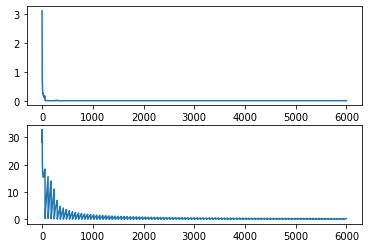

In [9]:
plt.figure()
fig, axs = plt.subplots(2)
axs[0].plot(all_D_losses)
axs[1].plot(all_G_losses)

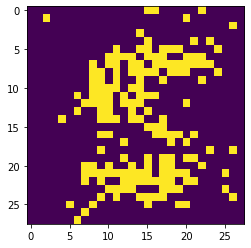

In [10]:
# Test

noise = torch.randn(1, 10 * 10).to(device)
generated_image = G(noise).view(28, 28).cpu().detach()


imshow(generated_image)


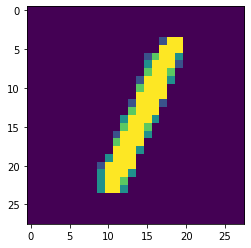

In [11]:
dataiter = iter(trainloader)

while(True):
    images, labels = dataiter.next()
    if labels[0] == 1:
        images = images.view(28, 28)
        imshow(images)
        break